In [1]:
#%reset -f
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PolyCollection #for plots polygons as rasters
import xarray as xr
from datetime import datetime, timedelta as delta
from matplotlib import path
from scipy.spatial import KDTree, cKDTree #c implementation is faster (to find nearest neighbor)
import os
import dask as da
from tqdm import tqdm
import glob
from scipy.interpolate import griddata #interpolation in space for non-uniform grids

In [7]:
#inputs----------
#path of directories
home_dir = "/export/lv4/user/jfajardourbina/"
dir_vel = f"{home_dir}dws_ulf_getm_2D_depth_avg/data/velocity/" #vel data
savee='everyM2' #saving track data every m2
deploy='everyM2'#deploy set of particles every m2
minTsim=60 #mimimum time of simulation (days)
maxTsim=91 #maximum time of simulation (days)
dir_tracks = f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/exp-deployHighVolume_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d/tracks/"
#files
files_vel_root="RE.DWS200m.uvz."
#parameters
npa_per_dep=12967 #number of particles per deployment
dx=400/1e3; dy=400/1e3 #particle grid resolution
#
#paths for output data
dir_post_proc_data=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/machine_learning_github/Lagrangian_ML/post_proc_data/"
dir_interp_bathymetry="bathymetry/"
file_interp_bathymetry="bathymetry_interp_to_particle_grid_for_convlstm.nc"

In [8]:
year_sim=2009;month_sim=5

#open any velocity file---
file_vel_path=f"{dir_vel}{files_vel_root}{year_sim}{month_sim:02d}01.nc" #:02d includes leading zeros (at the begin)
dsv=xr.open_dataset(file_vel_path,chunks={'xc':-1,'yc':-1,'time':110}) #chunks every 36h
xc=dsv.xc.values; yc=dsv.yc.values; h=dsv.bathymetry.values
mask=h.copy(); mask=xr.where(np.isfinite(mask),1,0) #mask ocean=1, land=0

#open any track file---
file_track=f'tracks_{year_sim}{month_sim:02d}_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d.nc'
file_track_path=f'{dir_tracks}{year_sim}/{file_track}'  
dst=xr.open_dataset(file_track_path)
x0=dst.x.isel(traj=range(npa_per_dep),obs=0).values
y0=dst.y.isel(traj=range(npa_per_dep),obs=0).values

In [9]:
#build grid (like the one of displacements)---
xmin=x0.min();xmax=x0.max();ymin=y0.min();ymax=y0.max()
extend_grid=10 #so from particle min max positions extend grid 10*dx (to not have problems with convolution)
xgrid=np.arange(xmin-dx*1e3*extend_grid,xmax+dx*1e3*(extend_grid+1),dx*1e3,dtype='float32')
ygrid=np.arange(ymin-dy*1e3*extend_grid,ymax+dy*1e3*(extend_grid+1),dy*1e3,dtype='float32')
xgrid0,ygrid0=np.meshgrid(xgrid,ygrid)

In [10]:
#interpolate h to particle-grid with nearest----
#
# for convolution we will have to set to 0 NaN values
ny,nx=h.shape
hg=np.reshape(h,(ny*nx))
xx,yy=np.meshgrid(xc.astype("float32"),yc.astype("float32"))
points=np.array([xx.flatten(),yy.flatten()]).T
hg = griddata(points, hg, (xgrid0, ygrid0), method='nearest')
print(np.sum(np.isnan(hg))) #land points = nan

#check if the same as using bathy every 2 points (as particle grid = 2 time bathy grid)
ix1=np.nonzero(xc==xgrid[0])[0][0]
ix2=np.nonzero(xc==xgrid[-1])[0][0]
iy1=np.nonzero(yc==ygrid[0])[0][0]
iy2=np.nonzero(yc==ygrid[-1])[0][0]
h2=h[iy1:iy2+1,ix1:ix2+1][::2,::2]
x2=xc[ix1:ix2+1][::2]; y2=yc[iy1:iy2+1][::2]
print(np.nansum(hg-h2)) #=0

#Saving data-----

dsout = xr.Dataset()
#global coords and attrs---
dsout.coords["y"] = ygrid
dsout["y"].attrs['description'] = 'y-position in meter'
dsout.coords["x"] = xgrid
dsout["x"].attrs['description'] = 'x-position in meter'
#
#variables---
#
dsout["bathymetry"] = (("y","x"),hg)
dsout["bathymetry"].attrs['long_name'] = 'bathymetry'
dsout["bathymetry"].attrs['description'] = 'spatial nearest interpolated'
dsout["bathymetry"].attrs['units'] = 'm'
#
dir_out_nc=dir_post_proc_data+dir_interp_bathymetry
dsout.to_netcdf(dir_out_nc+file_interp_bathymetry)
dsout.close(); del dsout

19854
0.0


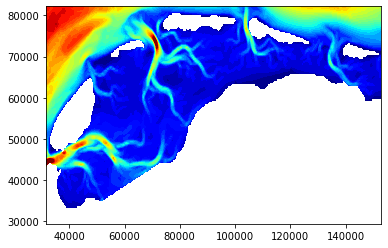

In [11]:
plt.contourf(xgrid0,ygrid0,hg,levels=np.arange(-2,32),extend='both',cmap='jet')

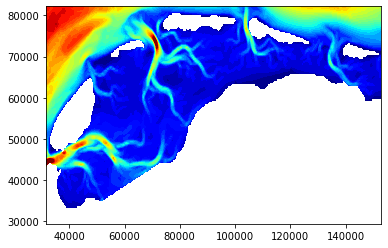

In [12]:
plt.contourf(x2,y2,h2,levels=np.arange(-2,32),extend='both',cmap='jet')
#plt.contourf(xc,yc,h,levels=np.arange(-2,32),cmap='jet')
#plt.axis([xgrid[0],xgrid[-1],ygrid[0],ygrid[-1]])